# Is apartment-type property cheaper than house-type on Airbnb?


## Introduction
### Background
Home-sharing platforms such as Airbnb have been growing since the last decade, the user count still climbing steadily to this day. The effects of such services on the hospitality sector is also increasing as these platforms scale up. The fact that Airbnb alone provides more listings than the top five hotel companies worldwide provide in total (Hartmans, 2017) presents a glimpse to the sheer market-dominant power of the home-sharing boom. Thus, as Airbnb becomes more common, home owners are finding Airbnb to be an increasingly lucrative way to use their property. Since they can now list their properties on Airbnb for an easy source of income, it is important to know what kind of properties are favored on the Airbnb market. For our analysis we will focus our statistical inference on one variable: the price of a listing. The goal of this analysis is to determine whether apartments are listed as noticeably more expensive than houses in the Airbnb database. Many parties, including real estate brokers, homebuyers, and property owners, can apply this information to help them make informed decisions.

### Preparation for Analysis

We define notations as follows:

- $\mu_h =$  population mean log price of house type listings

- $\mu_a =$ population mean log price of apartment type listings

- $x_h =$  sample mean log price of house type listings

- $x_a =$ sample mean log price of apartment type listings

- $\delta = \mu_h - \mu_a$

- $d = x_h - x_a$

- Null hypothesis $H_0: \delta = 0$

- Alternative hypothesis $H_1: \delta >0$


Through a preliminary examination, we observe that the point estimate, the difference in sample means, is greater than 0. $d = x_h - x_a = 0.0383 > 0$. We’d like to check if this is statistically significant using inference. In other words, we check if there is evidence to reject our null hypothesis $H_0: \delta = 0$. We set our alternative hypothesis as $H_1: \delta >0$ since we are interested in whether or not the difference in population means $\mu_h - \mu_a$ is greater than 0.

Our data is obtained from Kaggle and includes various characteristics of Airbnb listings, two of which we focus on in this project: natural log of price in US Dollars and house type.

## Preliminary Results

In [1]:
library(tidyverse)
library(tidymodels)
library(cowplot)
library(datateachr)
library(digest)
library(infer)
library(repr)
library(taxyvr)
library(tidyverse)
library(broom)
library(digest)
library(grid)
library(gridExtra)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.1     ✔ rsample      1.1.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.3     ✔ workflows    1.0.0
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.1     ✔ yardstick    1.1.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() ma

In [8]:
# read data
Airbnb <- read.csv("https://raw.githubusercontent.com/takumihoriba/stat201-project/main/data/train.csv") 
# head(Airbnb)

In [9]:
#Clean and wrangle the dataset into a tidy format
set.seed(320)
#choose needed column
Airbnb_tidy <- Airbnb |> select(log_price, property_type) |> filter(property_type %in% c("House", "Apartment")) 

nrow(Airbnb_tidy)
head(Airbnb_tidy,4)

[1] 65514

,log_price,property_type
,<dbl>,<chr>
1,5.010635,Apartment
2,5.129899,Apartment
3,4.976734,Apartment
4,6.620073,House


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



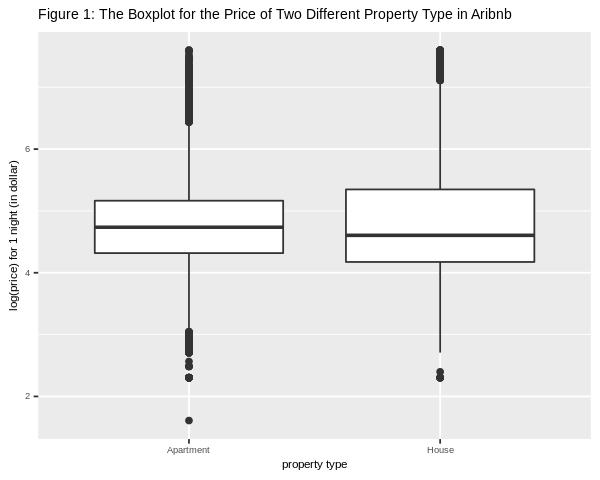

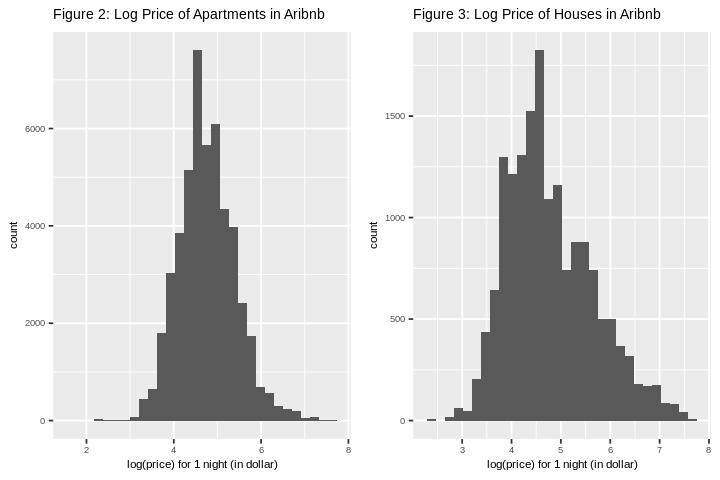

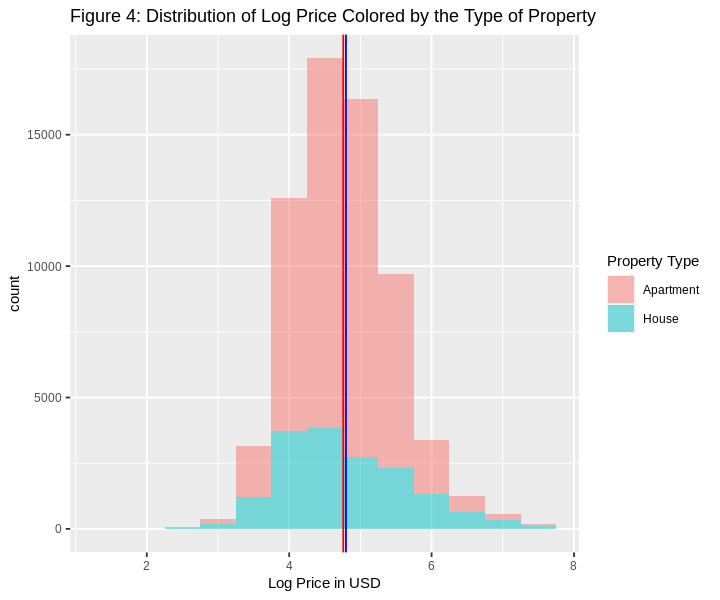

In [17]:
#Plot the relevant raw data
set.seed(320)

options(repr.plot.width = 5, repr.plot.height = 4)

#boxplot

log_price_boxplot <- ggplot(Airbnb_tidy,aes(x=property_type,y=log_price))+
                     geom_boxplot()+
                     labs(x="property type",y="log(price) for 1 night (in dollar)") +
                     theme(text=element_text(size=7))+
                     labs(title="Figure 1: The Boxplot for the Price of Two Different Property Type in Aribnb")
log_price_boxplot

Apartment_data <- Airbnb_tidy |> filter(property_type=="Apartment")

Apartment_distribution <- ggplot(Apartment_data,aes(x=log_price))+
                          geom_histogram()+
                          labs(x="log(price) for 1 night (in dollar)") +
                          theme(text=element_text(size=7))+
                          labs(title="Figure 2: Log Price of Apartments in Aribnb")

 House_data <- Airbnb_tidy |> filter(property_type=="House")

House_distribution <- ggplot(House_data,aes(x=log_price))+
                          geom_histogram()+
                          labs(x="log(price) for 1 night (in dollar)") +
                          theme(text=element_text(size=7))+
                          labs(title="Figure 3: Log Price of Houses in Aribnb")

sample_mean<- Airbnb_tidy |> group_by(property_type) |> summarize(sample_mean=mean(log_price))
compare_distribution <- Airbnb_tidy |>
                        ggplot(aes(x=log_price,fill=property_type))+
                        geom_histogram(binwidth=0.5,alpha=0.5)+
                        ggtitle("Figure 4: Distribution of Log Price Colored by the Type of Property")+
                        labs(fill="Property Type", x="Log Price in USD")+
                        theme(text=element_text(size=9))+
                        geom_vline(xintercept = sample_mean$sample_mean[1], color="red")+
                        geom_vline(xintercept = sample_mean$sample_mean[2],color="blue")

options(repr.plot.width = 6, repr.plot.height = 4)
grid.arrange(Apartment_distribution,House_distribution,ncol=2)
options(repr.plot.width = 6, repr.plot.height = 5)
compare_distribution

In [18]:
#estimate the parameter
set.seed(320)
prop_house_apartment <- Airbnb_tidy |>
group_by(property_type) |>
summarize(percent =  n()/nrow(Airbnb_tidy )) |>
arrange(desc(percent))
print("Table 1: the proportion of the property type") 
prop_house_apartment

[1] "Table 1: the proportion of the property type"


property_type,percent
<chr>,<dbl>
Apartment,0.7479775
House,0.2520225


In [19]:
set.seed(320)
Airbnb_summary <- Airbnb_tidy %>%  summary()
print("Table 2: summary") 
Airbnb_summary


[1] "Table 2: summary"


   log_price     property_type     
 Min.   :1.609   Length:65514      
 1st Qu.:4.277   Class :character  
 Median :4.700   Mode  :character  
 Mean   :4.768                     
 3rd Qu.:5.193                     
 Max.   :7.600                     

In [20]:
set.seed(320)
estimates<- Airbnb_tidy %>%
            group_by(property_type) %>%
            summarize(mean = mean(log_price),sd = sd(log_price))
print("Table 3: mean and sd value for aribnb dataset") 
estimates

[1] "Table 3: mean and sd value for aribnb dataset"


property_type,mean,sd
<chr>,<dbl>,<dbl>
Apartment,4.758850,0.6408249
House,4.797114,0.8758650


We observe $x_h > x_a \text{ which implies  } d > 0$.

In [23]:
# Calculate d
point_estimate = estimates$mean[2] -estimates$mean[1] 
point_estimate

[1] 0.03826355

## Method: Plan
Our point estimate is $d = 0.0383$. We will construct a confidence interval via theoretical methods to quantify the errors associated with our point estimate. To establish statistical significance, a hypothesis test (two-sample t-test) will be conducted with a significance level of 0.05. We will account for variance as part of the investigation of a scale parameter. As a result of this project, we anticipate that the mean price for house-type listings would be higher than that of apartment-type listings, as our sample means indicate. In order for our two sample t-test to be valid, we will verify the independence of observations within the samples as well as independence of the samples from each other. `set.seed()` will be used to ensure reproducibility of our analysis when randomness is involved.

## References
Airbnb price prediction. www.kaggle.com. [accessed 2023 Mar 18]. https://www.kaggle.com/datasets/stevezhenghp/airbnb-price-prediction?resource=download.

Barron K, Kung E, Proserpio D. 2020. The Effect of Home-Sharing on House Prices and Rents: Evidence from Airbnb. Marketing Science. 40(1). doi:https://doi.org/10.1287/mksc.2020.1227.

Cheng M, Foley C. 2018. The sharing economy and digital discrimination: The case of Airbnb. International Journal of Hospitality Management. 70:95–98. doi:https://doi.org/10.1016/j.ijhm.2017.11.002.

Garcia-López M-À, Jofre-Monseny J, Martínez-Mazza R, Segú M. 2020. Do short-term rental platforms affect housing markets? Evidence from Airbnb in Barcelona. Journal of Urban Economics. 119:103278. doi:https://doi.org/10.1016/j.jue.2020.103278. https://www.sciencedirect.com/science/article/pii/S0094119020300498.

Guttentag DA, Smith SLJ. 2017. Assessing Airbnb as a disruptive innovation relative to hotels: Substitution and comparative performance expectations. International Journal of Hospitality Management. 64:1–10. doi:https://doi.org/10.1016/j.ijhm.2017.02.003. https://www.sciencedirect.com/science/article/pii/S0278431916302250.

Horn K, Merante M. 2017. Is home sharing driving up rents? Evidence from Airbnb in Boston. Journal of Housing Economics. 38:14–24. doi:https://doi.org/10.1016/j.jhe.2017.08.002.

Kwok L, Xie KL. 2018 Oct. Pricing strategies on Airbnb: Are multi-unit hosts revenue pros? International Journal of Hospitality Management. doi:https://doi.org/10.1016/j.ijhm.2018.09.013.

Mody MA, Suess C, Lehto X. 2017. The accommodation experiencescape: a comparative assessment of hotels and Airbnb. International Journal of Contemporary Hospitality Management. 29(9):2377–2404. doi:https://doi.org/10.1108/ijchm-09-2016-0501.

Wachsmuth D, Weisler A. 2018. Airbnb and the rent gap: Gentrification through the sharing economy. Environment and Planning A: Economy and Space. 50(6):1147–1170. doi:https://doi.org/10.1177/0308518x18778038.

ZERVAS G, PROSERPIO D, BYERS JW. 2017. The Rise of the Sharing Economy: Estimating the Impact of Airbnb on the Hotel Industry. Journal of Marketing Research. 54(5):687–705. https://www.jstor.org/stable/44878526.